In [61]:
!pip install category_encoders
!pip3 install xgboost==1.7.2
!pip3 install eli5

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install scikit-learn==1.1.3
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, n

In [26]:
import pandas as pd
import glob
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from category_encoders import OrdinalEncoder, OneHotEncoder

from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from scipy.stats.distributions import uniform
from sklearn.metrics import roc_auc_score, classification_report

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [2]:
data_list = glob.glob('/content/drive/MyDrive/project/*.csv')
data = pd.DataFrame()
data_list.sort()
data_list

['/content/drive/MyDrive/project/2009.csv',
 '/content/drive/MyDrive/project/2010.csv',
 '/content/drive/MyDrive/project/2011.csv',
 '/content/drive/MyDrive/project/2012.csv',
 '/content/drive/MyDrive/project/2013.csv',
 '/content/drive/MyDrive/project/2014.csv',
 '/content/drive/MyDrive/project/2015.csv',
 '/content/drive/MyDrive/project/2016.csv',
 '/content/drive/MyDrive/project/2017.csv',
 '/content/drive/MyDrive/project/2018.csv',
 '/content/drive/MyDrive/project/2019.csv',
 '/content/drive/MyDrive/project/2020.csv',
 '/content/drive/MyDrive/project/2021.csv',
 '/content/drive/MyDrive/project/2022.csv']

In [3]:
for dat in data_list:
  year = dat[-8:-4]
  df = pd.read_csv(dat, encoding='euc-kr')
  df['연도'] = df[df.columns[0]]
  df['연도'] = int(year)
  data = data.append(df)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132757 entries, 0 to 71041
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   지역 구분        1132757 non-null  int64  
 1   행정구역(시도)     1132757 non-null  int64  
 2   학교급 구분       1132757 non-null  int64  
 3   사교육 참여시간     1132757 non-null  float64
 4   학생 성별        1132757 non-null  int64  
 5   학생 성적 구분     933037 non-null   float64
 6   부의 연령        1089350 non-null  object 
 7   부의 교육정도      1085378 non-null  object 
 8   모의 연령        1101138 non-null  object 
 9   모의 교육정도      1094928 non-null  object 
 10  가구소득         1132757 non-null  int64  
 11  방과후 학교 참여시간  1059388 non-null  float64
 12  방과후 학교       1020564 non-null  float64
 13  어학연수비        830378 non-null   float64
 14  사교육비         1099388 non-null  float64
 15  연도           1132757 non-null  int64  
dtypes: float64(6), int64(6), object(4)
memory usage: 146.9+ MB


In [5]:
df = data.copy()

df.replace({'행정구역(시도)':{11:'서울', 21:'부산', 22:'대구', 23:'인천', 24:'광주', 25:'대전',26:'울산', 29:'세종', 31:'경기', 32:'강원', 33:'충북', 34:'충남', 35:'전북', 36:'전남', 37:'경북', 38:'경남', 39:'제주'}}, inplace = True)
df.replace({'지역 구분':{1:'서울', 2:'광역시', 3:'중소도시', 4:'읍면지역'}},inplace=True)
df.replace({'학교급 구분':{1:'초등학교', 2:'중학교', 3:'일반고', 4:'특성화고'}},inplace=True)
df.replace({'학생 성별':{1:'남학생', 2:'여학생'}},inplace=True)
df.replace({'학생 성적 구분':{1:'0%~10%', 2:'11~30%', 3:'31~60%', 4:'61~80%', 5:'81~100%'}},inplace=True)
df.replace({'모의 연령':{'1':1, '2':2, '3':3, '.':0}},inplace=True)
df.replace({'부의 연령':{'1':1, '2':2, '3':3, '.':0}},inplace=True)
df.replace({'모의 교육정도':{'1':1, '2':2, '3':3, '4':4, '.':0}},inplace=True)
df.replace({'부의 교육정도':{'1':1, '2':2, '3':3, '4':4, '.':0}},inplace=True)
df = df.sort_values(by = '연도').reset_index(drop=True)
df

,지역 구분,행정구역(시도),학교급 구분,사교육 참여시간,학생 성별,학생 성적 구분,부의 연령,부의 교육정도,모의 연령,모의 교육정도,가구소득,방과후 학교 참여시간,방과후 학교,어학연수비,사교육비,연도
0,서울,서울,초등학교,0.0,남학생,0%~10%,1.0,4.0,1.0,3.0,4,8.000000,39.4,0.0,0.000000,2009
1,중소도시,충남,일반고,4.0,남학생,11~30%,3.0,4.0,3.0,3.0,7,20.000000,111.0,0.0,230.500000,2009
2,중소도시,충남,일반고,4.0,남학생,11~30%,3.0,2.0,3.0,2.0,4,3.000000,11.4,0.0,598.400000,2009
3,중소도시,충남,일반고,4.0,남학생,11~30%,2.0,3.0,2.0,2.0,7,3.000000,11.4,0.0,399.000000,2009
4,중소도시,충남,일반고,4.0,남학생,11~30%,2.0,2.0,2.0,2.0,5,3.000000,11.4,0.0,718.100000,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132752,광역시,광주,일반고,0.0,남학생,81~100%,3.0,31.0,3.0,31.0,8,0.000000,0.0,NaN,0.000000,2022
1132753,광역시,광주,일반고,0.0,남학생,81~100%,3.0,31.0,3.0,31.0,4,0.000000,0.0,NaN,0.000000,2022
1132754,광역시,광주,일반고,0.0,남학생,81~100%,3.0,31.0,3.0,31.0,2,0.000000,0.0,NaN,0.000000,2022
1132755,광역시,광주,일반고,0.0,남학생,81~100%,3.0,31.0,3.0,41.0,7,0.000000,0.0,NaN,0.000000,2022


In [6]:
df_2014 = df.query('연도 < 2015')
df_2015 = df.query('연도 > 2014')

df_2014.replace({'모의 연령':{1:'20~30대', 2:'40대', 3:'50대이상', np.nan:'무응답', 0:'무응답'}},inplace=True)
df_2014.replace({'부의 연령':{1:'20~30대', 2:'40대', 3:'50대이상', np.nan:'무응답', 0:'무응답'}},inplace=True)

df_2015.replace({'모의 연령':{1:'20~30대', 2:'20~30대', 3:'40대', 4:'50대이상', 5:'50대이상', np.nan:'무응답', 0:'무응답'}},inplace=True)
df_2015.replace({'부의 연령':{1:'20~30대', 2:'20~30대', 3:'40대', 4:'50대이상', 5:'50대이상', np.nan:'무응답', 0:'무응답'}},inplace=True)

df_2015['모의 교육정도'] = df_2015['모의 교육정도']/10//1
df_2015['부의 교육정도'] = df_2015['부의 교육정도']/10//1

df_2014.replace({'모의 교육정도':{1:'중졸이하', 2:'고졸', 3:'대졸', 4: '대학원졸', np.nan:'무응답', 0:'무응답'}},inplace=True)
df_2014.replace({'부의 교육정도':{1:'중졸이하', 2:'고졸', 3:'대졸', 4: '대학원졸', np.nan:'무응답', 0:'무응답'}},inplace=True)

df_2015.replace({'모의 교육정도':{1:'중졸이하', 2:'중졸이하', 3:'고졸', 4:'대졸', 5:'대졸', 6:'대학원졸', 7:'대학원졸', np.nan:'무응답', 0:'무응답'}},inplace=True)
df_2015.replace({'부의 교육정도':{1:'중졸이하', 2:'중졸이하', 3:'고졸', 4:'대졸', 5:'대졸', 6:'대학원졸', 7:'대학원졸', np.nan:'무응답', 0:'무응답'}},inplace=True)

df1 = pd.concat([df_2014, df_2015], ignore_index=True)

df1

,지역 구분,행정구역(시도),학교급 구분,사교육 참여시간,학생 성별,학생 성적 구분,부의 연령,부의 교육정도,모의 연령,모의 교육정도,가구소득,방과후 학교 참여시간,방과후 학교,어학연수비,사교육비,연도
0,서울,서울,초등학교,0.0,남학생,0%~10%,20~30대,대학원졸,20~30대,대졸,4,8.000000,39.4,0.0,0.000000,2009
1,중소도시,충남,일반고,4.0,남학생,11~30%,50대이상,대학원졸,50대이상,대졸,7,20.000000,111.0,0.0,230.500000,2009
2,중소도시,충남,일반고,4.0,남학생,11~30%,50대이상,고졸,50대이상,고졸,4,3.000000,11.4,0.0,598.400000,2009
3,중소도시,충남,일반고,4.0,남학생,11~30%,40대,대졸,40대,고졸,7,3.000000,11.4,0.0,399.000000,2009
4,중소도시,충남,일반고,4.0,남학생,11~30%,40대,고졸,40대,고졸,5,3.000000,11.4,0.0,718.100000,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132752,광역시,광주,일반고,0.0,남학생,81~100%,40대,고졸,40대,고졸,8,0.000000,0.0,NaN,0.000000,2022
1132753,광역시,광주,일반고,0.0,남학생,81~100%,40대,고졸,40대,고졸,4,0.000000,0.0,NaN,0.000000,2022
1132754,광역시,광주,일반고,0.0,남학생,81~100%,40대,고졸,40대,고졸,2,0.000000,0.0,NaN,0.000000,2022
1132755,광역시,광주,일반고,0.0,남학생,81~100%,40대,고졸,40대,대졸,7,0.000000,0.0,NaN,0.000000,2022


In [7]:
df_2016 = df1.query('연도 < 2017')
df_2017 = df1.query('연도 > 2016')

df_2016.replace({'가구소득':{1:'100만원 미만', 2:'100~199만원', 3:'200~299만원', 4:'300~399만원', 5:'400~499만원', 6:'500~599만원', 7:'600~699만원', 8:'700만원 이상'}},inplace=True)
df_2017.replace({'가구소득':{1:'200만원 미만', 2:'200~299만원', 3:'300~399만원', 4:'400~499만원', 5:'500~599만원', 6:'600~699만원', 7:'700~799만원', 8:'800만원 이상'}},inplace=True)

df2 = pd.concat([df_2016, df_2017], ignore_index=True)
df2.replace({'학생 성적 구분':{np.nan:'무응답'}},inplace=True)
df2.fillna(0, inplace = True)
df2 = df2.drop(['사교육 참여시간', '방과후 학교 참여시간'], axis = 1)
print(df2.사교육비.quantile(q=0.75))
df2['고사교육비'] = df2['사교육비'] > df2.사교육비.quantile(q=0.75)
df2 = df2.drop(['사교육비'],axis=1)
df2.replace({'고사교육비':{False:0, True:1}},inplace = True)

df2

499.5


,지역 구분,행정구역(시도),학교급 구분,학생 성별,학생 성적 구분,부의 연령,부의 교육정도,모의 연령,모의 교육정도,가구소득,방과후 학교,어학연수비,연도,고사교육비
0,서울,서울,초등학교,남학생,0%~10%,20~30대,대학원졸,20~30대,대졸,300~399만원,39.4,0.0,2009,0
1,중소도시,충남,일반고,남학생,11~30%,50대이상,대학원졸,50대이상,대졸,600~699만원,111.0,0.0,2009,0
2,중소도시,충남,일반고,남학생,11~30%,50대이상,고졸,50대이상,고졸,300~399만원,11.4,0.0,2009,1
3,중소도시,충남,일반고,남학생,11~30%,40대,대졸,40대,고졸,600~699만원,11.4,0.0,2009,0
4,중소도시,충남,일반고,남학생,11~30%,40대,고졸,40대,고졸,400~499만원,11.4,0.0,2009,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132752,광역시,광주,일반고,남학생,81~100%,40대,고졸,40대,고졸,800만원 이상,0.0,0.0,2022,0
1132753,광역시,광주,일반고,남학생,81~100%,40대,고졸,40대,고졸,400~499만원,0.0,0.0,2022,0
1132754,광역시,광주,일반고,남학생,81~100%,40대,고졸,40대,고졸,200~299만원,0.0,0.0,2022,0
1132755,광역시,광주,일반고,남학생,81~100%,40대,고졸,40대,대졸,700~799만원,0.0,0.0,2022,0


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132757 entries, 0 to 1132756
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   지역 구분     1132757 non-null  object 
 1   행정구역(시도)  1132757 non-null  object 
 2   학교급 구분    1132757 non-null  object 
 3   학생 성별     1132757 non-null  object 
 4   학생 성적 구분  1132757 non-null  object 
 5   부의 연령     1132757 non-null  object 
 6   부의 교육정도   1132757 non-null  object 
 7   모의 연령     1132757 non-null  object 
 8   모의 교육정도   1132757 non-null  object 
 9   가구소득      1132757 non-null  object 
 10  방과후 학교    1132757 non-null  float64
 11  어학연수비     1132757 non-null  float64
 12  연도        1132757 non-null  int64  
 13  고사교육비     1132757 non-null  int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 121.0+ MB


In [80]:
X = df2.drop('고사교육비',axis=1)
y = df2.고사교육비
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42, stratify = y_train)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

# baseline score을 확인합니다.
y_base = [1] * len(y_train)
print('roc_auc score:', roc_auc_score(y_train, y_base))
print(classification_report(y_train, y_base))

(724964, 13) (181241, 13) (226552, 13) (724964,) (181241,) (226552,)
roc_auc score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    543786
           1       0.25      1.00      0.40    181178

    accuracy                           0.25    724964
   macro avg       0.12      0.50      0.20    724964
weighted avg       0.06      0.25      0.10    724964



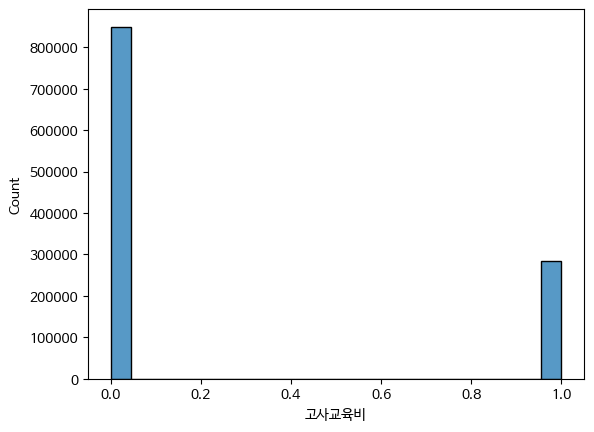

In [10]:
plt.rc('font', family='NanumBarunGothic')
sns.histplot(y)

In [12]:
model = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.1,
    ),
)

params = {
    "xgbclassifier__max_depth": [4, 6, 8, 10],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__learning_rate": [0.05, 0.1, 0.15],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    )

}

randomized_search = RandomizedSearchCV(
    model,
    param_distributions=params,
    scoring="roc_auc",
    n_iter=5,
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=8, xgbclassifier__min_child_weight=8;, score=0.804 total time= 1.7min
[CV 2/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=8, xgbclassifier__min_child_weight=8;, score=0.803 total time= 1.7min
[CV 3/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=8, xgbclassifier__min_child_weight=8;, score=0.804 total time= 1.7min
[CV 1/3] END xgbclassifier__colsample_bytree=0.8898455001363846, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=8, xgbclassifier__min_child_weight=4;, score=0.804 total time= 2.1min
[CV 2/3] END xgbclassifier__colsample_bytree=0.8898455001363846, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=8, xgbclassifier__min_child_weight=

In [13]:
y_train_pred = randomized_search.best_estimator_.predict(X_train)
y_val_pred = randomized_search.best_estimator_.predict(X_val)
y_test_pred = randomized_search.best_estimator_.predict(X_test)

In [14]:
print('roc_auc score:', roc_auc_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

roc_auc score: 0.6492355564604482
              precision    recall  f1-score   support

           0       0.82      0.93      0.87    543786
           1       0.64      0.37      0.47    181178

    accuracy                           0.79    724964
   macro avg       0.73      0.65      0.67    724964
weighted avg       0.77      0.79      0.77    724964



In [15]:
print('roc_auc score:', roc_auc_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

roc_auc score: 0.644276929470546
              precision    recall  f1-score   support

           0       0.81      0.93      0.87    135946
           1       0.64      0.36      0.46     45295

    accuracy                           0.79    181241
   macro avg       0.72      0.64      0.66    181241
weighted avg       0.77      0.79      0.77    181241



In [16]:
print('roc_auc score:', roc_auc_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

roc_auc score: 0.6458534639237312
              precision    recall  f1-score   support

           0       0.81      0.93      0.87    169934
           1       0.63      0.36      0.46     56618

    accuracy                           0.79    226552
   macro avg       0.72      0.65      0.66    226552
weighted avg       0.77      0.79      0.77    226552



In [17]:
randomized_search.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['지역 구분', '행정구역(시도)', '학교급 구분', '학생 성별',
                                      '학생 성적 구분', '부의 연령', '부의 교육정도', '모의 연령',
                                      '모의 교육정도', '가구소득'],
                                mapping=[{'col': '지역 구분',
                                          'data_type': dtype('O'),
                                          'mapping': 중소도시    1
광역시     2
읍면지역    3
서울      4
NaN    -2
dtype: int64},
                                         {'col': '행정구역(시도)',
                                          'data_type': dtype('O'),
                                          'mapping': 경기      1
인천      2
강원      3
대전      4
부산      5
충남      6
전남      7
전북      8
서울      9
충북     10
제주     11
광주     12
울산     13
경남     14
대구     15
경북     16
세종     17
NaN    -2
dtype: i...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.05,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=8, max_leaves=0, min_child_weight=8,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               predictor='auto', random_state=42, ...))])

In [18]:
X_test_preprocessed = randomized_search.best_estimator_[0].transform(X_test.copy())

permuter = PermutationImportance(
    randomized_search.best_estimator_[1],  
    scoring="roc_auc",  
    n_iter=5,  
    random_state=42,
)
    

permuter.fit(X_test_preprocessed, y_test)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.6872700594236812,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.05, max_bin=256,
                                              max_cat_threshold=64,
                                              max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=8,
                                              max_leaves=0, min_child_weight=8,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=42, ...),
                      random_state=42, scoring='roc_auc')

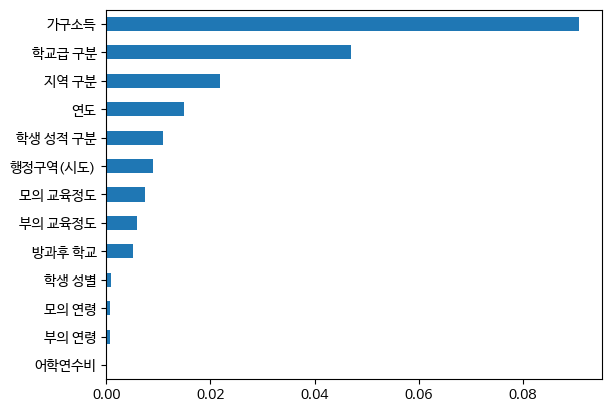

In [19]:
feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()

In [20]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names,
)

Weight,Feature
0.0907 ± 0.0016,가구소득
0.0470 ± 0.0006,학교급 구분
0.0218 ± 0.0006,지역 구분
0.0149 ± 0.0005,연도
0.0109 ± 0.0003,학생 성적 구분
0.0090 ± 0.0003,행정구역(시도)
0.0075 ± 0.0005,모의 교육정도
0.0059 ± 0.0004,부의 교육정도
0.0051 ± 0.0003,방과후 학교
0.0010 ± 0.0001,학생 성별


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132757 entries, 0 to 1132756
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   지역 구분     1132757 non-null  object 
 1   행정구역(시도)  1132757 non-null  object 
 2   학교급 구분    1132757 non-null  object 
 3   학생 성별     1132757 non-null  object 
 4   학생 성적 구분  1132757 non-null  object 
 5   부의 연령     1132757 non-null  object 
 6   부의 교육정도   1132757 non-null  object 
 7   모의 연령     1132757 non-null  object 
 8   모의 교육정도   1132757 non-null  object 
 9   가구소득      1132757 non-null  object 
 10  방과후 학교    1132757 non-null  float64
 11  어학연수비     1132757 non-null  float64
 12  연도        1132757 non-null  int64  
 13  고사교육비     1132757 non-null  int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 121.0+ MB


([<matplotlib.axis.XTick at 0x7fec59612eb0>,
 <a list of 12 Text xticklabel objects>)

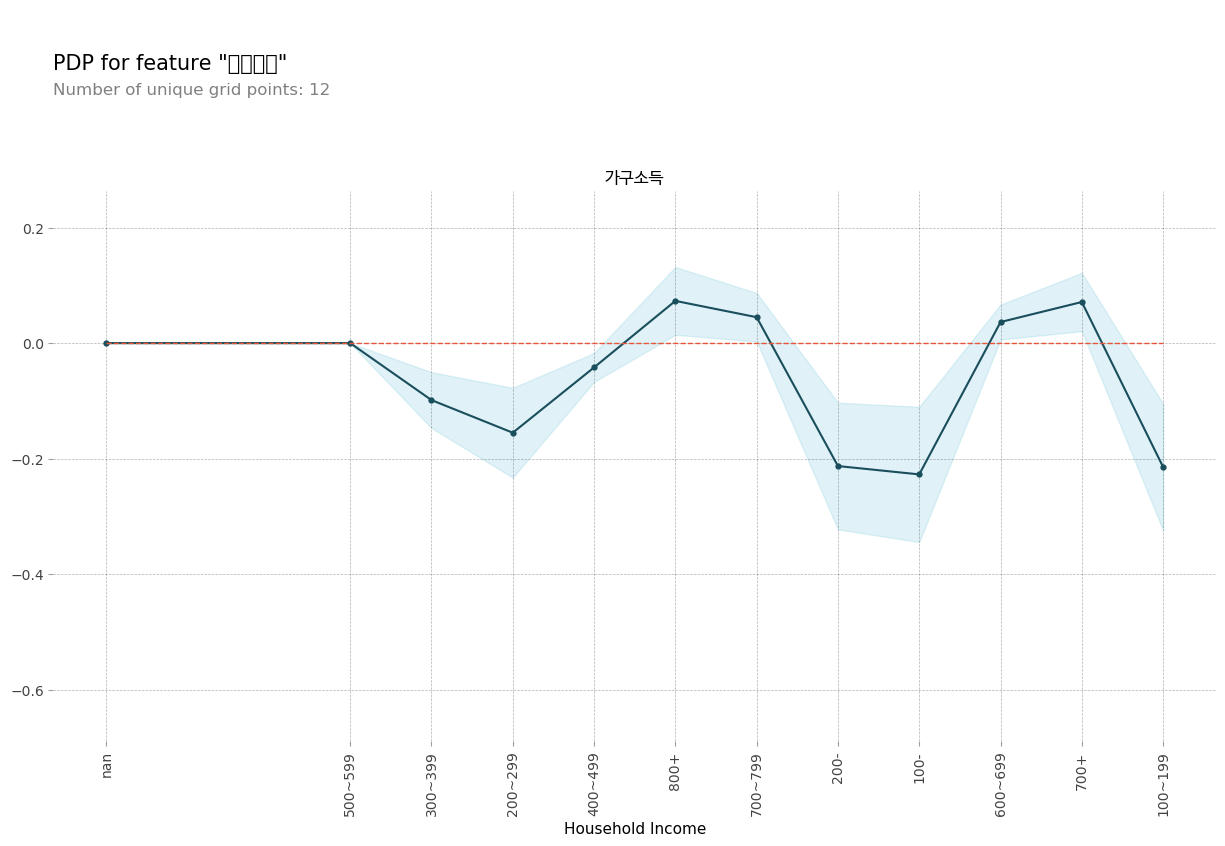

In [51]:
target_feature = "가구소득"
plt.rc('font', family='NanumBarunGothic')

mappings = randomized_search.best_estimator_[0].mapping
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
maps = mapping_data[0]["mapping"]
pdp_dist = pdp_isolate(
    model=randomized_search.best_estimator_[1],
    dataset=X_test_preprocessed,
    model_features=X_test.columns,
    feature=target_feature,
    cust_grid_points=[-2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)

encoded_features = maps.values.tolist()
original_features = ['500~599','300~399','200~299','400~499','800+','700~799','200-','100-','600~699','700+','100~199',np.nan]

fig, ax = pdp_plot(pdp_dist, target_feature)
plt.rc('font', family='NanumBarunGothic')
plt.title('가구소득')
plt.xlabel('Household Income')
plt.xticks(encoded_features, original_features, rotation=90)

([<matplotlib.axis.XTick at 0x7fec5941b3a0>,
 <a list of 4 Text xticklabel objects>)

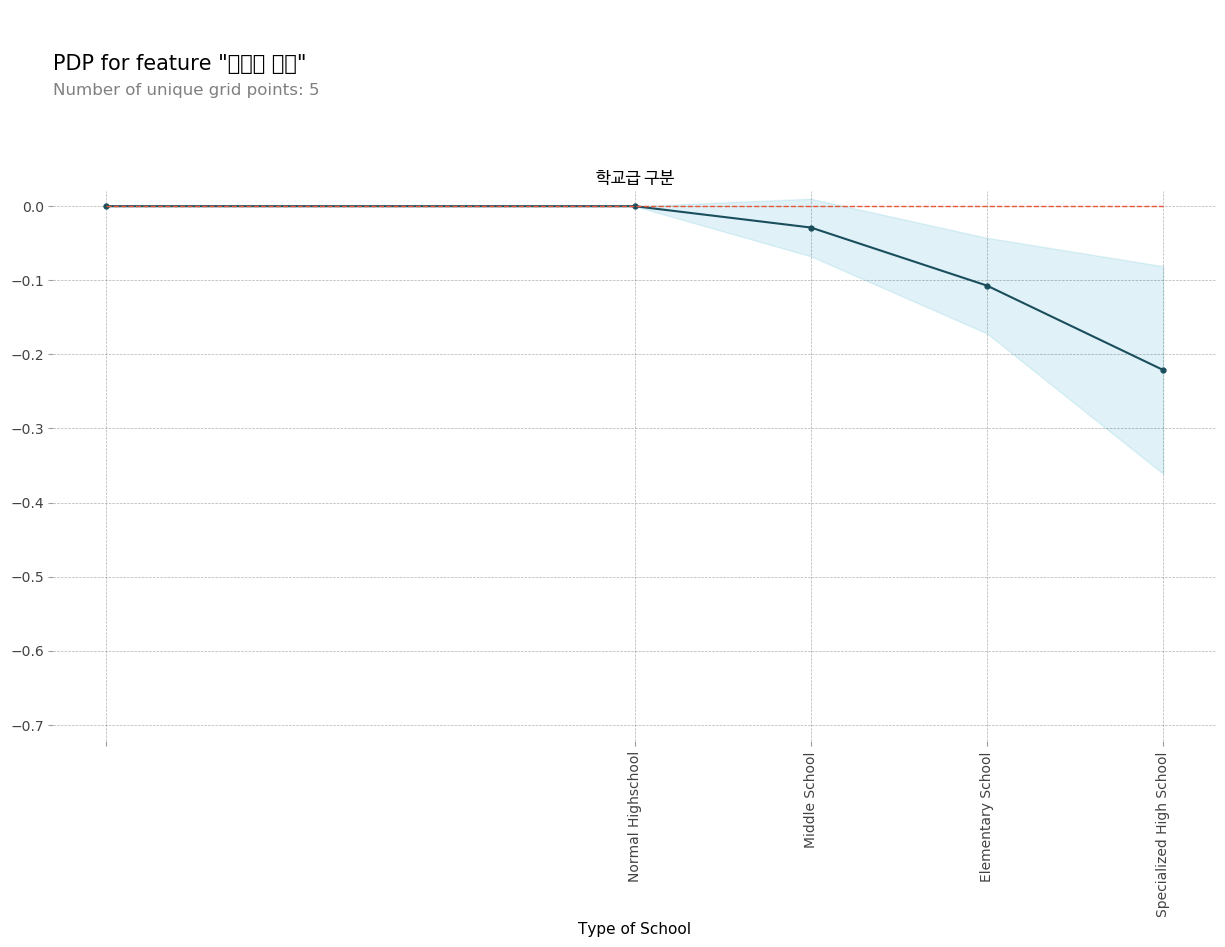

In [57]:
target_feature = "학교급 구분"
plt.rc('font', family='NanumBarunGothic')

mappings = randomized_search.best_estimator_[0].mapping
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
maps = mapping_data[0]["mapping"]
encoded_features = maps.values.tolist()
original_features = ['Normal Highschool', 'Middle School', 'Elementary School', 'Specialized High School']

pdp_dist = pdp_isolate(
    model=randomized_search.best_estimator_[1],
    dataset=X_test_preprocessed,
    model_features=X_test.columns,
    feature=target_feature,
    cust_grid_points=[-2, 1, 2, 3, 4],  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)

fig, ax = pdp_plot(pdp_dist, target_feature)
plt.rc('font', family='NanumBarunGothic')
plt.title('학교급 구분')
plt.xlabel('Type of School')
plt.xticks(encoded_features, original_features, rotation=90)

([<matplotlib.axis.XTick at 0x7fec59253cd0>,
 <a list of 5 Text xticklabel objects>)

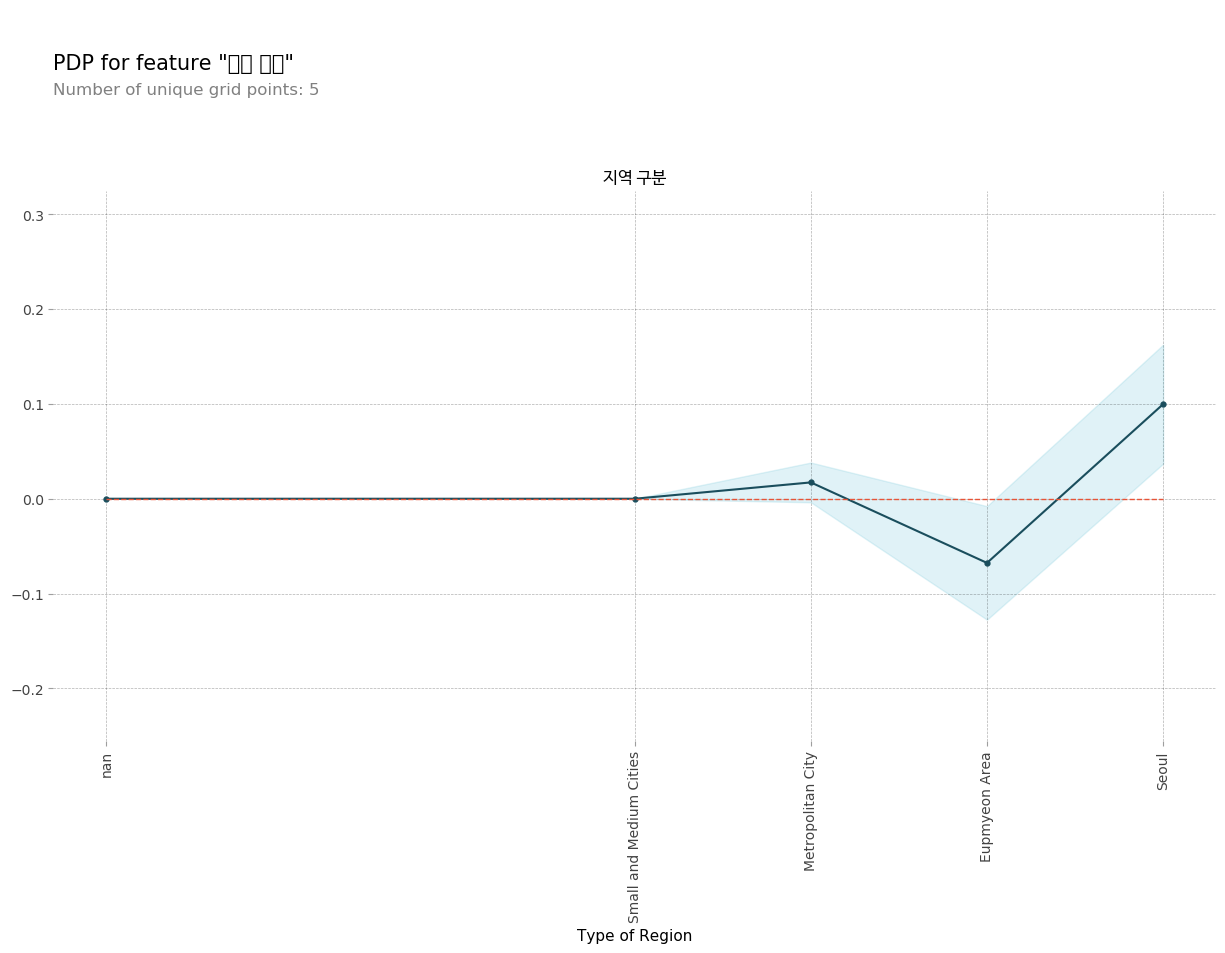

In [62]:
target_feature = "지역 구분"
plt.rc('font', family='NanumBarunGothic')

mappings = randomized_search.best_estimator_[0].mapping
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
maps = mapping_data[0]["mapping"]
encoded_features = maps.values.tolist()
original_features = ['Small and Medium Cities', 'Metropolitan City', 'Eupmyeon Area', 'Seoul', np.nan]

pdp_dist = pdp_isolate(
    model=randomized_search.best_estimator_[1],
    dataset=X_test_preprocessed,
    model_features=X_test.columns,
    feature=target_feature,
    cust_grid_points=[-2, 1, 2, 3, 4],  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)

fig, ax = pdp_plot(pdp_dist, target_feature)
plt.rc('font', family='NanumBarunGothic')
plt.title('지역 구분')
plt.xlabel('Type of Region')
plt.xticks(encoded_features, original_features, rotation=90)

([<matplotlib.axis.XTick at 0x7fec59173e20>,
 <a list of 18 Text xticklabel objects>)

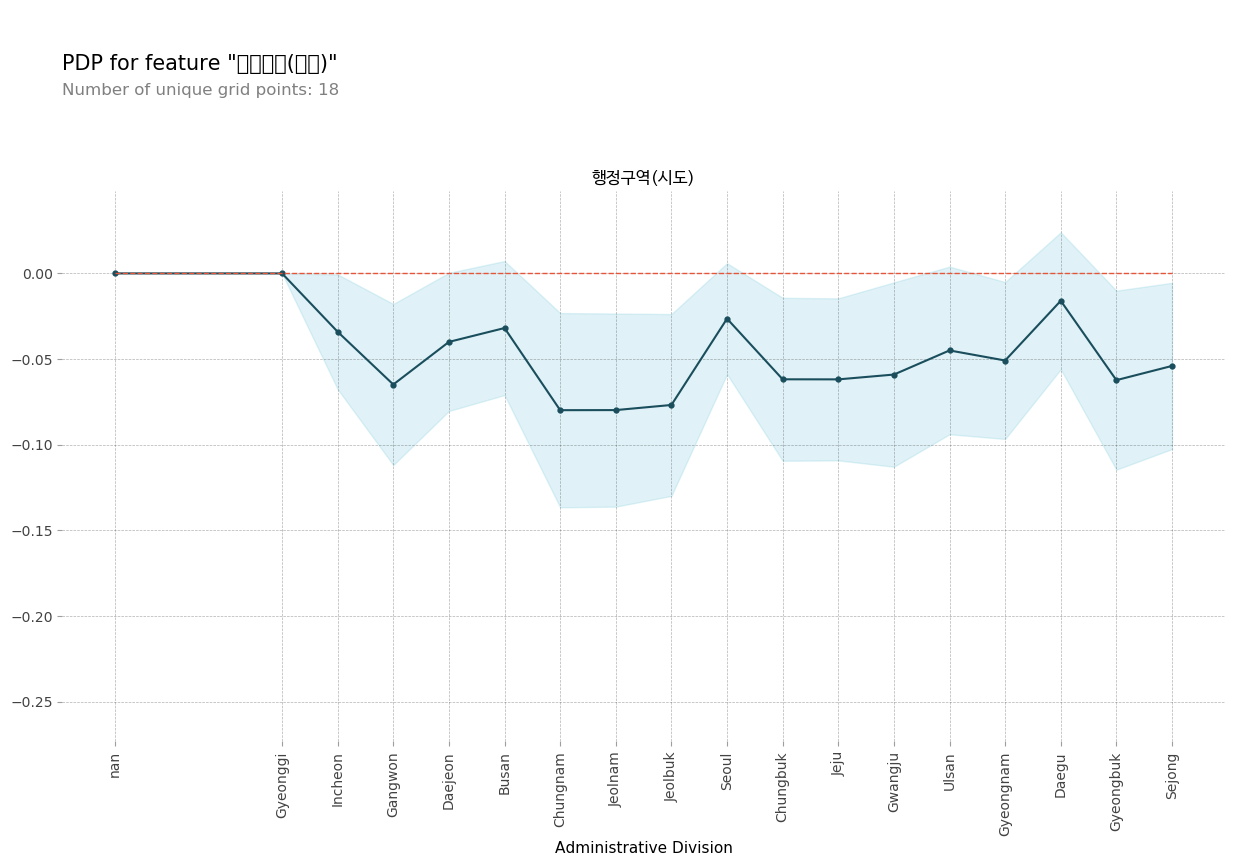

In [67]:
target_feature = "행정구역(시도)"
plt.rc('font', family='NanumBarunGothic')

mappings = randomized_search.best_estimator_[0].mapping
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
maps = mapping_data[0]["mapping"]
encoded_features = maps.values.tolist()
original_features = ['Gyeonggi',
 'Incheon',
 'Gangwon',
 'Daejeon',
 'Busan',
 'Chungnam',
 'Jeolnam',
 'Jeolbuk',
 'Seoul',
 'Chungbuk',
 'Jeju',
 'Gwangju',
 'Ulsan',
 'Gyeongnam',
 'Daegu',
 'Gyeongbuk',
 'Sejong',
 np.nan]

pdp_dist = pdp_isolate(
    model=randomized_search.best_estimator_[1],
    dataset=X_test_preprocessed,
    model_features=X_test.columns,
    feature=target_feature,
    cust_grid_points=[-2, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17],  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)

fig, ax = pdp_plot(pdp_dist, target_feature)
plt.rc('font', family='NanumBarunGothic')
plt.title('행정구역(시도)')
plt.xlabel('Administrative Division')
plt.xticks(encoded_features, original_features, rotation=90)

Text(0.5, 0, 'Year')

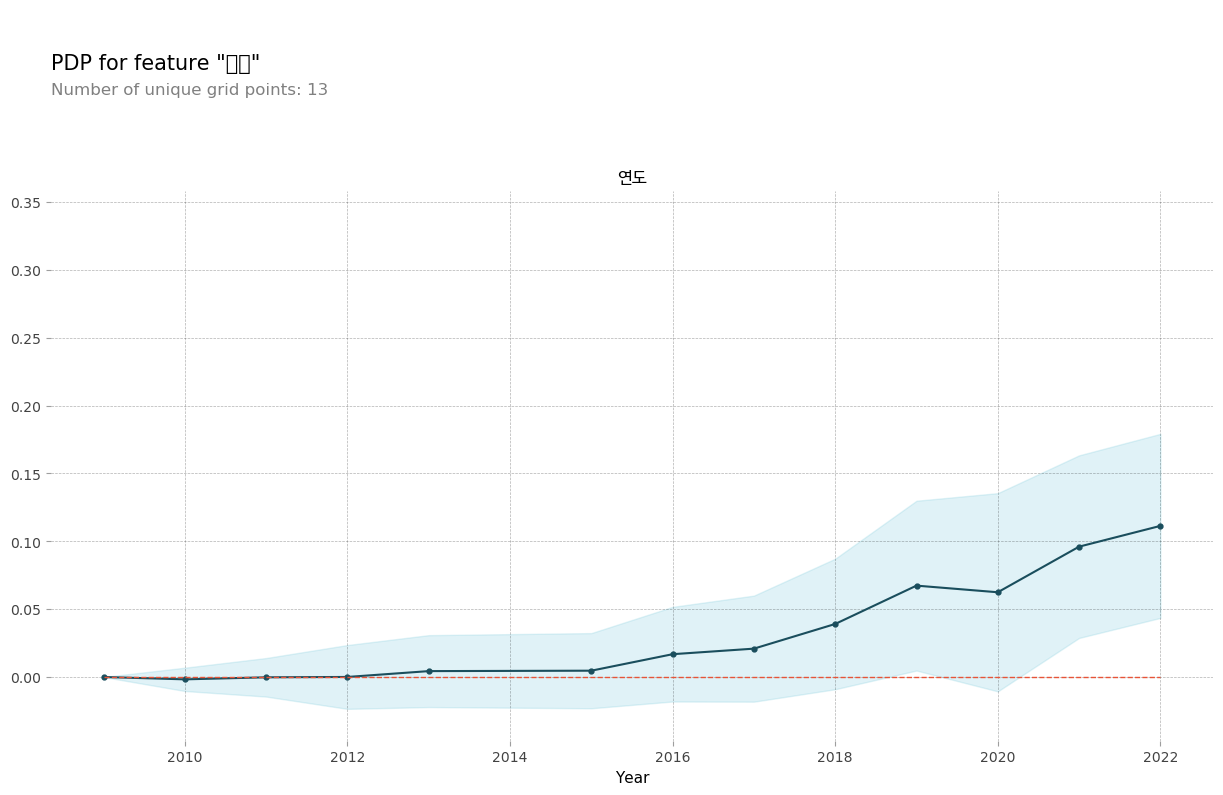

In [73]:
target_feature = "연도"
plt.rc('font', family='NanumBarunGothic')

pdp_dist = pdp_isolate(
    model=randomized_search.best_estimator_[1],
    dataset=X_test_preprocessed,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=14,
)

fig, ax = pdp_plot(pdp_dist, target_feature)
plt.rc('font', family='NanumBarunGothic')
plt.title('연도')
plt.xlabel('Year')

([<matplotlib.axis.XTick at 0x7fec590750d0>,
 <a list of 7 Text xticklabel objects>)

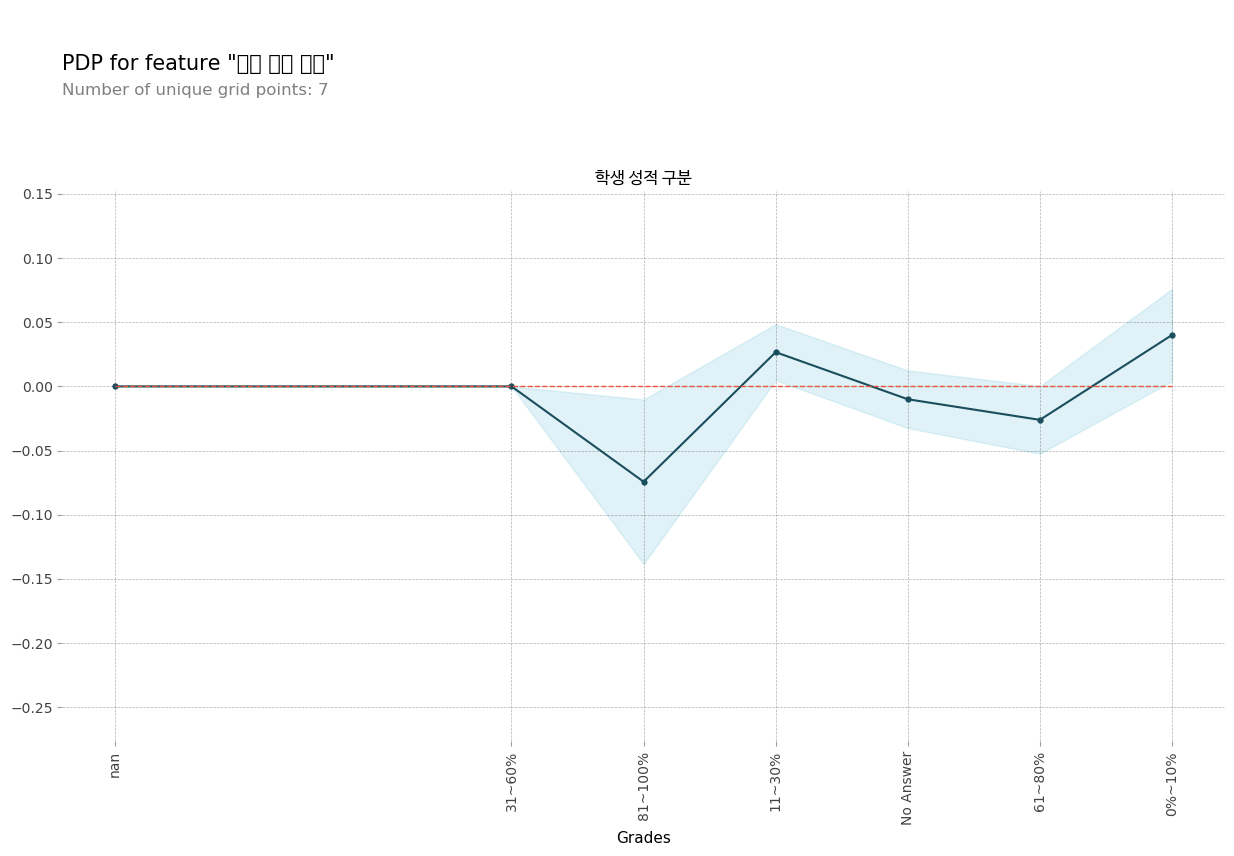

In [76]:
target_feature = "학생 성적 구분"
plt.rc('font', family='NanumBarunGothic')

mappings = randomized_search.best_estimator_[0].mapping
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
maps = mapping_data[0]["mapping"]
encoded_features = maps.values.tolist()
original_features = ['31~60%', '81~100%', '11~30%', 'No Answer', '61~80%', '0%~10%', np.nan]

pdp_dist = pdp_isolate(
    model=randomized_search.best_estimator_[1],
    dataset=X_test_preprocessed,
    model_features=X_test.columns,
    feature=target_feature,
    cust_grid_points=[-2, 1, 2, 3, 4,5,6],  # 특성값을 찍어 볼 지점을 직접 지정할 수 있습니다.
)

fig, ax = pdp_plot(pdp_dist, target_feature)
plt.rc('font', family='NanumBarunGothic')
plt.title('학생 성적 구분')
plt.xlabel('Grades')
plt.xticks(encoded_features, original_features, rotation=90)